<h2 style="text-align:center;">Module import</h2>

In [175]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 5000)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge as krr
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.cluster import DBSCAN

import optuna
from functools import partial

<h2 style="text-align:center;">Load Data</h2>

In [443]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
print(f'train size: {train.shape}')
print(f'test size: {test.shape}')

train size: (1460, 81)
test size: (1459, 80)


<h1 style="text-align:center;">EDA</h1>

<h3 style="text-align:center;">1. Exploring dependent variables</h3><br>
<h4>Outline</h4>
The dependent variable is a continuous variable. The goal is to solve the regression analysis problem.<br>
In order to improve the performance of the linear models, the dependent variables and residuals must satisfy <b>'normality'</b>.<br><br>

<h4>Normality</h4>
Normality means that the distribution of variables follows a normal distribution.<br>
The easiest way to test normality is to draw a histogram and a QQ plot.<br>
It is recommended that the histogram form a bell shape. It is good to understand to see skewness and kurtosis together.<br>
I thought that if skewness is between 0 and 0.5 and kurtosis is between 1 and 8, the shape of the histogram is similar to that of a bell.<br>
If there is a shape extending along the baseline to the top right in the QQ plot, we can see that the data has normality.<br><br>
If it violates normality, log transformation or boxcox transformation can be applied.

SalePrice's skew: 1.8812964895244009
SalePrice's kurt: 6.523066888485879


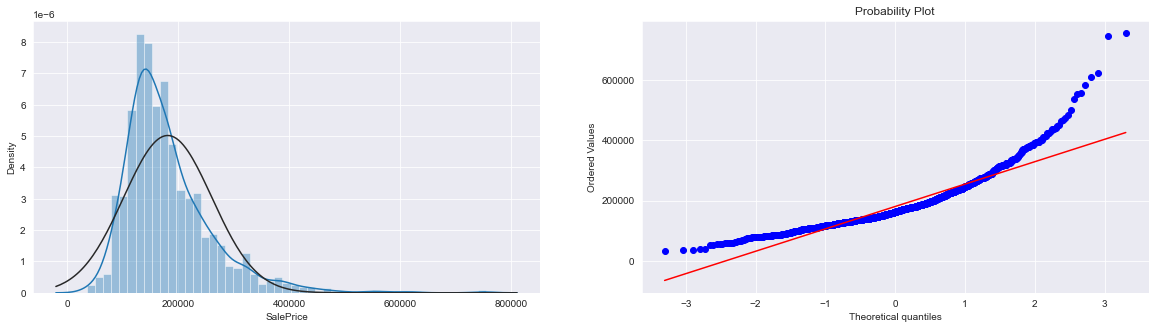

In [136]:
print(f"SalePrice's skew: {train.SalePrice.skew()}")
print(f"SalePrice's kurt: {train.SalePrice.kurt()}")
f, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.distplot(train.SalePrice, fit=norm, ax=ax[0])
probplot(train.SalePrice, plot=ax[1])
plt.show()

<p>
    <font color='red'>Conclusion:</font><br>
    Because the histogram is skewed to the left (skewness > 0), and the points of the QQ plot are out of the baseline,<br>
    It is necessary to convert to satisfy normality through variable transformation such as log transformation.
</p>

Check whether there is a missing value of the dependent variable.

In [139]:
print(f"SalePrice'missing count: {train.SalePrice.isnull().sum()}")

SalePrice'missing count: 0


<h3 style="text-align:center;">2. Exploring independent variables - Define Type</h3><br>
<h4>Outline</h4>
<p>
    Variable search means reading data_description and determining type of variables.<br>
    We can read the description of the variable, determine the type of variable, and further derive ideas for generating derived variables and converting data.<br><br>
    The types of variables are classified as follows.<br>
    <ol>
        <li>Categorical</li>
        <ol>
            <li>Nominal vars</li>
            <li>Order(Rank) vars</li>
        </ol>
        <li>Continuous</li>
        <ol>
            <li>Interval vars</li>
            <li>Ratio vars</li>
        </ol>
    </ol>
    The method of searching and preprocessing is determined by the type of variable.<br>
    <br>
    By using Pandas, we can find out the data type (numerical type and object) of the variable.<br>
    However, not all numerical variables can be determined as continuous variables.<br>
    I divided them subjectively by referring to data_description.<br>
    <br>
    Criteria (subjective)
    <ol>
        <li>
            Nominal type: Not related by category or item.<br>
            ex) Country, type
        </li>
        <li>
            Rank (order) type: Rank, order, and comparison are possible for each category and item.<br>
            ex) Grade, quality, etc.
        </li>
        <li>
            Continuous: A numerical variable that can be expressed continuously in a real interval.<br>
            ex) Feet, number, etc.
        </li>
    </ol>
</p>

Check numerical and object variables.

In [8]:
num_vars = train.columns[train.dtypes != 'object']
obj_vars = train.columns[train.dtypes == 'object']

In [9]:
pd.DataFrame(num_vars, columns=['num vars']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
num vars,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice


In [10]:
pd.DataFrame(obj_vars, columns=['obj vars']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
obj vars,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition


Explore some variables for example.<br><br>
<b>MSSubClass</b><br>
MSSubClass is a variable representing the type of residence.<br>
Although it is numerical, it is actually a categorical variable.<br>
I was able to read the description of each category in detail and find keywords representing 'order' like keywords such as 'Older' and 'Newer'.<br>
Therefore, MSSubClass was defined as an ordered variable.<br>
<br>
+Going further<br>
Looking at the description of MSSubClass, it can be seen that the category contains the following meanings.
1) Residential style.<br>
2) Years.<br>
3) The number of floors.<br><br>
The above items are all included in YearBuilt, HouseStyle, and BldgType, so they overlap.<br>
Instead, several categories have an additional meaning of 'PUD'.<br>
Therefore, it is possible to attempt to add a nominal derivative variable with a binary value based on PUD in the future.<br>
In addition, 1945 and 1946 often appear in explanations.<br>
Since this period may have an important domain meaning, it can be used when exploring YeaBuilt in the future.
<br><br>
<b>MSZoning</b><br>
MSZoning has a category. Each item is defined as a nominal variable because it does not have an order or ranking with each other.<br><br>
<b>LotFrontage</b><br>
LotFrontage is a continuous variable because it is a feet value.
<br><br>
<b>Street and Alley</b><br>
Street and Ally are nominal variables because there is no order and ranking.<br>
However, except for the NA value, They have Grvl or Pave. These variables are okay to be processed with ordered variables (applying label encoding instead of one hot encoding).<br><br>
+Going further<br>
Ally may have a negative meaning (NA) value.<br>
In the previous study, I learned that negative values can be recorded as missing values.<br>
Therefore, if there is a missing value, it can be directly replaced with a value such as None.
<br><br>
<b>OverallQual and OverallCond</b><br>
OverallQual and OverallCond are numerical but have categories.<br>
It can be seen that each item has a meaning related to quality. Therefore, it is a ranking variable.<br>
Ranked variables apply label encoding to preserve the meaning of values. However, there is no need to separately encode ranked variables that have already been expressed in sequential figures, such as 1 to 10.<br>
So I just included it in the continuous variable.
<br><br>
<b>ExterQual and ExterCond</b><br>
ExterQual and ExterCond are categories.
<br><br>
<b>BsmtFullBath and BsmtHalfBath</b><br>
In fact, the two variables commonly refer to the number of Bathrooms.<br>
I can think of creating a dataset with the same meaning as fewer variables by combining variables with one variable (ex) BsmtFullBath + 0.5 * BsmtHalfBath).
<br><br>
<b>Fence</b><br>
Fence is categorical and can be defined as a ranking variable because the item has a quality-related meaning.<br>
However, it is divided into a private case and a Wood case.<br>
Therefore, I can think that I can divide it into Privacy and Wood.
<br><br>
<b>MoSold and YrSold</b><br>
I treated variables such as YearBuild and YearEmodAdd as continuous variables.<br>
But when I checked the number of values in MoSold and YrSold (I used value_counts), the number of values were small enough to be treated as order variables.<br>
Therefore, the two variables were defined as order variables.<br><br>
I conducted the above search for all variables (if there is anything wrong or better idea, please comment).<br><br>
Now we can define the types of all variables.

In [362]:
nominal_vars = [
    'MSZoning', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 
    'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
    'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 
    'MiscFeature', 'SaleType', 'SaleCondition'
]

In [363]:
order_vars = [
    'MSSubClass', 'Street', 'Alley', 'LotShape', 'LandSlope', 'ExterQual', 
    'ExterCond', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
    'PoolQC', 'Fence', 'Functional', 'GarageFinish', 'PavedDrive', 'MoSold', 'YrSold'
]

In [364]:
continuous_vars = [
    'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
    'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
    'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
    'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 
    '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'
]

+After determining the types of all variables, I checked if there were any missing variables.<br><br>
I compared the number of columns in the training set with the sum of self-defined variables and found that the number was different(Except Id, SalePrice).<br>
I found in the data_description that the variables expressed in Bedroom and Kitchen are actually Bedroom AbvGr and Kitchen AbvGr. These were defined as continuous variables.

In [14]:
len(train.columns) == (len(nominal_vars) + len(order_vars)
                       + len(continuous_vars)) + len(set(['Id', 'SalePrice']))

True

<p>
    <font color='red'>Conclusion:</font><br>
    We defined the types of all variables.<br>
    This process can be effective in the pretreatment part later.
</p>

<h3 style="text-align:center;">3. Exploring independent variables - Check the missing values</h3><br>
<h4>Outline</h4>
We need to make sure that missing values exist for all variables.<br>
isnull().Sum() can be used to find missing values.

In [15]:
all_data = pd.concat((train, test)).drop(['SalePrice'], axis=1)
cnt_missing = all_data.isnull().sum().sort_values(ascending=False)
cnt_percent = cnt_missing / all_data.shape[0]
missing_table = pd.DataFrame([cnt_missing, cnt_percent], 
                             index=['missing count', 'missing percent']).T
missing_table = missing_table[missing_table['missing count'] > 0]

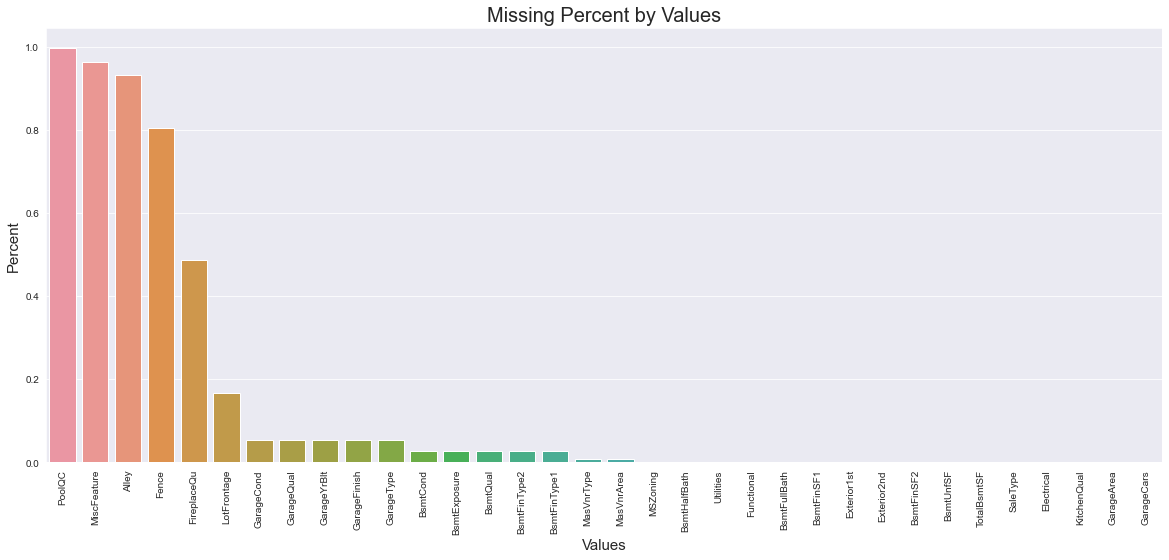

In [16]:
f, ax = plt.subplots(figsize=(20, 8))
sns.barplot(x=missing_table.index, y=missing_table['missing percent'])
plt.title('Missing Percent by Values', size=20)
plt.xlabel('Values', size=15)
plt.ylabel('Percent', size=15)
plt.xticks(rotation='90')
plt.show()

<p>
    <font color='red'>Conclusion:</font><br>
    Many variables have missing values.<br>
    Some variables have extremely large amounts of missing values.<br>
    We previously found category variables with negative meanings.<br>
    Maybe we can handle them easily.
</p>

<h3 style="text-align:center;">4. Bivariate search - correlation analysis, heat map, finding important variables</h3><br>
<h4>Outline</h4>
Correlation analysis is a technique to find out the correlation between the two variables.<br>
We can find variables with relatively strong <b>'linearity'</b> using the correlation coefficient with the dependent variable.<br>
I designated these variables as relatively important variables and tested <b>'homogeneity'</b>.<br>
In addition, I tested <b>'independence'</b> through the correlation between independent variables.<br>
<br>
<h4>Some assumptions for a good regression model</h4>
Previously, we checked the normality of the dependent variable and the residual.<br>
In addition, several more assumptions are needed.<br>
<ol>
    <li>
        <b>Linearity</b>:<br>
        It is recommended that the independent variable and the dependent variable have a linear relationship.<br>
        The 'variable transformation' or 'dimensional increase' method can help to have linearity.
    </li>
    <li>
        <b>homogeneity:</b>:<br>
        The variance of the residuals must be constant.<br>
        Drawing a residual diagram for an independent variable can test the equal variance.<br>
        If the points follow randomly based on the baseline, they satisfy the equal variance.
    </li>
    <li>
        <b>Independence</b>:<br>
        Independence means that there should be no correlation between independent variables.<br>
        The high correlation between independent variables causes multicollinearity. As a result, the performance of the model becomes incredible.
    </li>
    <li>
        <b>Irregularity</b>:<br>
        There should be no correlation between residuals.<br>
        Durbin-Watson' helps test for non-correlation.
    </li>
</ol>

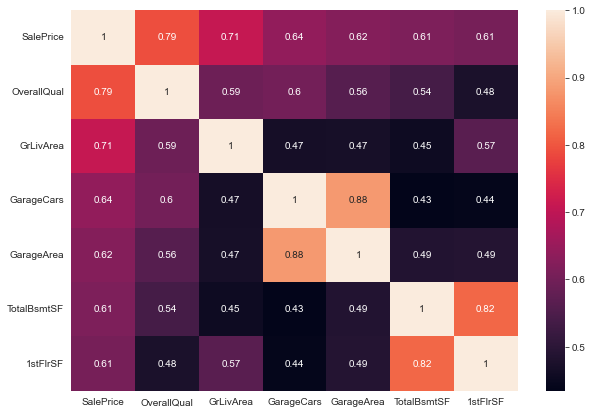

In [17]:
f, ax = plt.subplots(figsize=(10, 7))
highcorr_vars = (abs(train.corr().SalePrice).sort_values(ascending=False)[:7]).index
sns.heatmap(train[highcorr_vars].corr(), annot=True)
plt.show()

In [18]:
def hypo_test(x, y, cat=False):
    f, ax = plt.subplots(1, 4, figsize=(25, 5))
    if cat:
        sns.boxplot(x=train[x], y=train[y], ax=ax[0])
    else:
        sns.scatterplot(x=train[x], y=train[y], ax=ax[0])
        sns.regplot(x=train[x], y=train[y], ax=ax[0])
    sns.residplot(x=train[x], y=train[y], ax=ax[1])
    sns.distplot(train[x], fit=norm, ax=ax[2])
    probplot(train[x], plot=ax[3])
    plt.show()

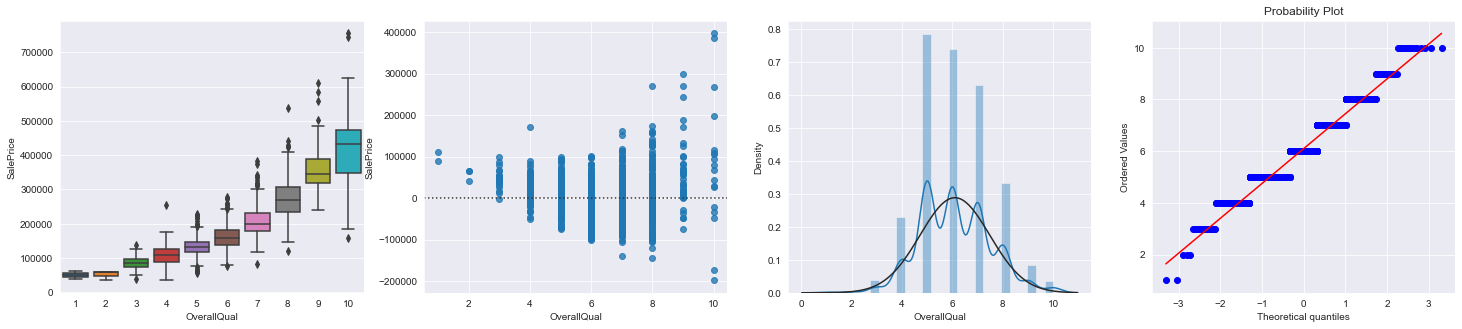

In [19]:
hypo_test('OverallQual', 'SalePrice', True)

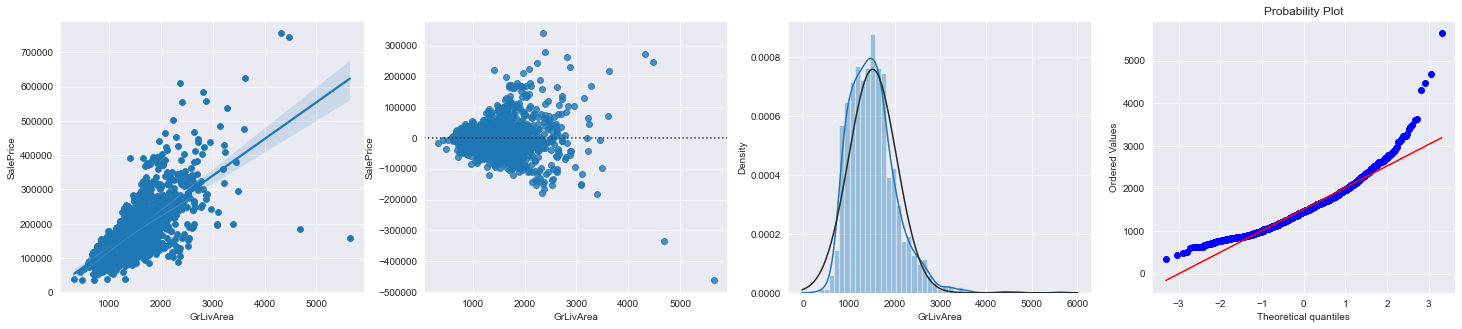

In [20]:
hypo_test('GrLivArea', 'SalePrice')

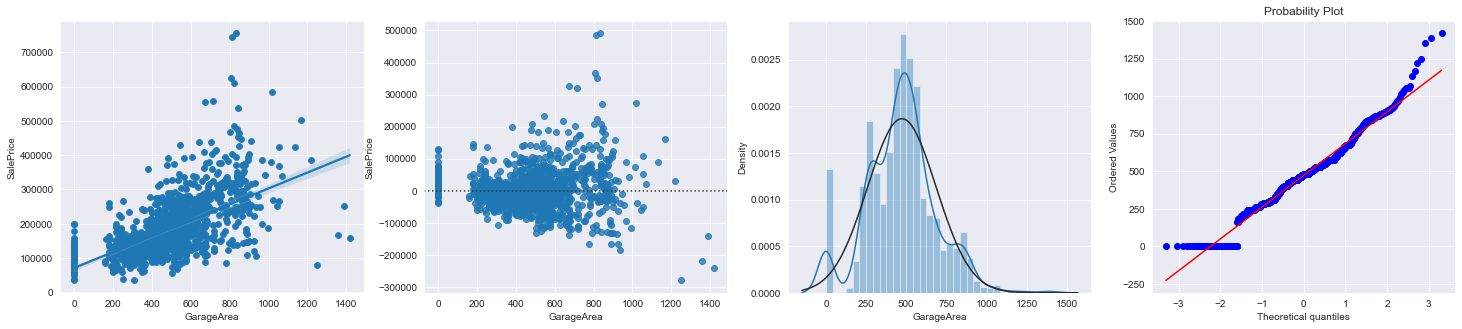

In [21]:
hypo_test('GarageArea', 'SalePrice')

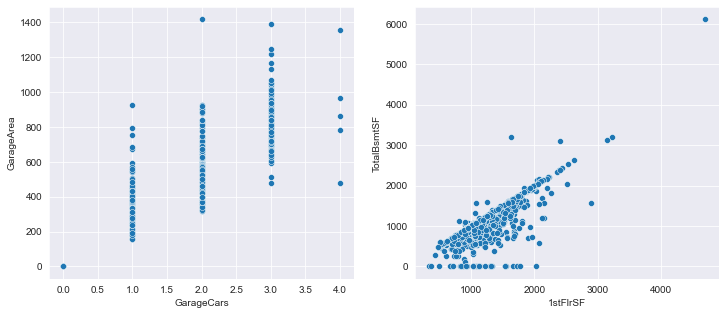

In [22]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.scatterplot(y=train.GarageArea, x=train.GarageCars, ax=ax[0])
sns.scatterplot(x=train['1stFlrSF'], y=train.TotalBsmtSF, ax=ax[1])
plt.show()

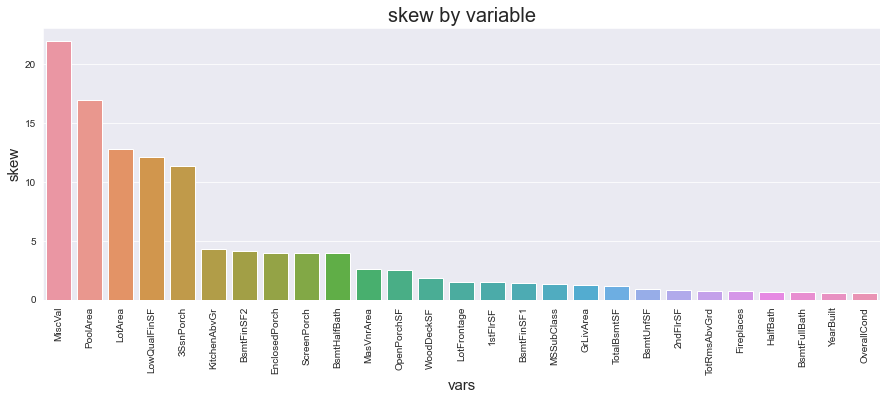

In [23]:
skews = abs(all_data.skew()).sort_values(ascending=False)
kurts = abs(all_data.kurt()).sort_values(ascending=False)
skew_kurt_table = pd.DataFrame([skews, kurts], index=['skew', 'kurt']).T
ntv = skew_kurt_table[skew_kurt_table['skew'] > 0.5].index

plt.subplots(figsize=(15, 5))
sns.barplot(x=skew_kurt_table.loc[ntv].index, y=skew_kurt_table.loc[ntv]['skew'])
plt.xticks(rotation='90')
plt.title('skew by variable', size=20)
plt.xlabel('vars', size=15)
plt.ylabel('skew', size=15)
plt.show()

<p>
    결론:<br>
    나는 SalePrice에 대한 각 변수의 상관성을 분석했고, OverallQual, GrLivArea, CarArea 등의 변수들이 높은 선형성을 가졌음을 확인했다.<br>
    박스플롯과 산점도를 사용해서 선형성을 시각화해보았다.<br>
    그리고 나는 이 변수들을 중요한 변수라고 생각해서 이들을 대상으로 등분산성 검정을 위한 잔차도, 정규성 검정을 위한 히스토그램, QQplot을 그려보았다.<br>
    <br>
    각 변수들은 잔차도의 포인트들이 랜덤하게 뿌려지지 않고 어떤 패턴이나 모양을 가지고 있어서 등분산성을 만족하지 않는다.<br>
    나는 히스토그램과 QQplot의 결과를 통해 각 변수들이 이상적인 정규성을 갖지 않는다는 것을 확인할 수 있었다.<br>
    로그변환이나 박스콕스 변환을 통해 위 문제들을 해소할 수 있다.<br>
    <br>
    몇몇 독립변수들이 서로 상관성을 가지는 것도 확인할 수 있었다. 역시 산점도로 시각화해보았다.<br>
    독립변수 간의 높은 상관성은 다중공선성을 일으킨다. 모델의 설명력이 신뢰도를 잃게된다.<br>
    나는 당장 변수를 선택하거나 차원축소를 사용하기보단 규제화를 사용하기로 했다.<br>
    선형모델은 규제화(norm1, norm2)를 통해 위 문제를 해소할 수 있다.<br>
    <br>
    나는 모든 변수들을 대상으로 시각화하기 어려워서 왜도와 첨도를 통해 변환이 필요한 독립변수들을 살펴보았다.
</p>

<h2 style='text-align: center'>Preprocessing</h2>

<h3 style="text-align:center;">1. Remove ID</h3><br>
<h4>Outline</h4>
분석에 필요없는 ID 변수를 제거해준다.

In [444]:
train_id = train.Id
test_id = test.Id
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

<h3 style="text-align:center;">2. Clensing - Outlier</h3><br>
<h4>Outline</h4>
이상치가 존재하는 데이터셋은 모형의 성능을 하락시킬 수 있다.<br>
훈련데이터에 존재하는 이상치를 제거해주는 것은 선택사항이다. 나는 종속변수와 강한 상관성을 가진 변수의 산점도에서 두 개의 이상치를 발견했다.<br>
두 포인트는 직선 상에서 크게 벗어난 장소에 위치해있었다.<br><br>

<h4>이상치 찾기</h4>
<ol>
    <li><b>단변량에 대한 통계값 - 정규분포, IQR:</b><br>독립변수를 대상으로 정규분포나 우도함수, IQR 등을 사용해서 threshold를 벗어나는 포인트를 이상치로 판단할 수 있다.<br>
        하지만 threshold를 벗어난 포인트가 항상 이상치라고 판단할 수 없다. 예를 들어 GrLivArea의 산점도에는 우측 최상단에 두 개의 포인트가 떨어져있다.<br>
        이들은 다른 포인트와 값이 크게 차이나지만 선형성을 입증할 수 있어서 중요하다.<br>따라서 단변량에 대한 이상치 판단은 주의해서 다룰 필요가 있다.</li>
    <li><b>산점도:</b><br>어떤 패턴(예를 들면 선형관계)을 갖는 두 변수의 산점도를 그리면 직관적으로 이상치를 찾을 수 있다.<br>
        나는 앞서 종속변수와 강한 상관성을 갖는 변수들을 일부 찾아냈다. GrLivArea의 산점도를 통해 두 개의 이상치를 찾아냈다.</li>
    <li><b>군집화 - DBSCAN:</b><br>DBSCAN은 거리를 사용해서 이상치를 검출할 수 있다.<br>
        DBSCAN은 정해진 범위(epsilon)와 필요한 주변 포인트(min_samples)를 가지며, 핵심 포인트와 주변 포인트를 계산해서 군집을 생성한다,<br>
        주변에 핵심 포인트가 없고 필요한 최소의 이웃 포인트를 갖지 못한 포인트들은 이상치가 된다.<br>
        나는 GrLivArea와 SalePrice를 대상으로 스케일링을 적용 후 DBSCAN을 사용해보았다.<br></li>
</ol>

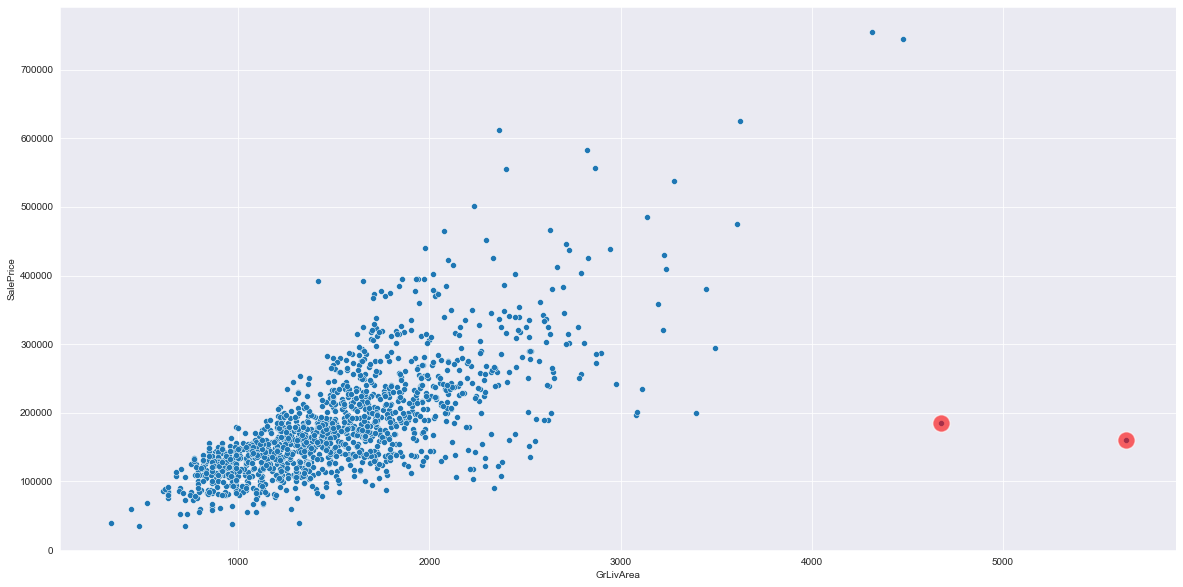

In [445]:
plt.subplots(figsize=(20, 10))
outlier_idx = train.GrLivArea.sort_values(ascending=False)[:2].index
sns.scatterplot(x=train['GrLivArea'], y=train.SalePrice)
sns.scatterplot(x=train.iloc[outlier_idx]['GrLivArea'], y=train.iloc[outlier_idx].SalePrice, color='r', s=300, alpha=.6)
plt.show()

In [202]:
scaled_data = pd.DataFrame(StandardScaler().fit_transform(train[['GrLivArea', 'SalePrice']]), columns=['GrLivArea', 'SalePrice'])
dbscan_model = DBSCAN(eps=1.5, min_samples=3).fit(scaled_data)
tmp = pd.concat((scaled_data, pd.DataFrame(dbscan_model.labels_, columns=['label'])), axis=1)

In [203]:
tmp.label.value_counts()

 0    1456
-1       4
Name: label, dtype: int64

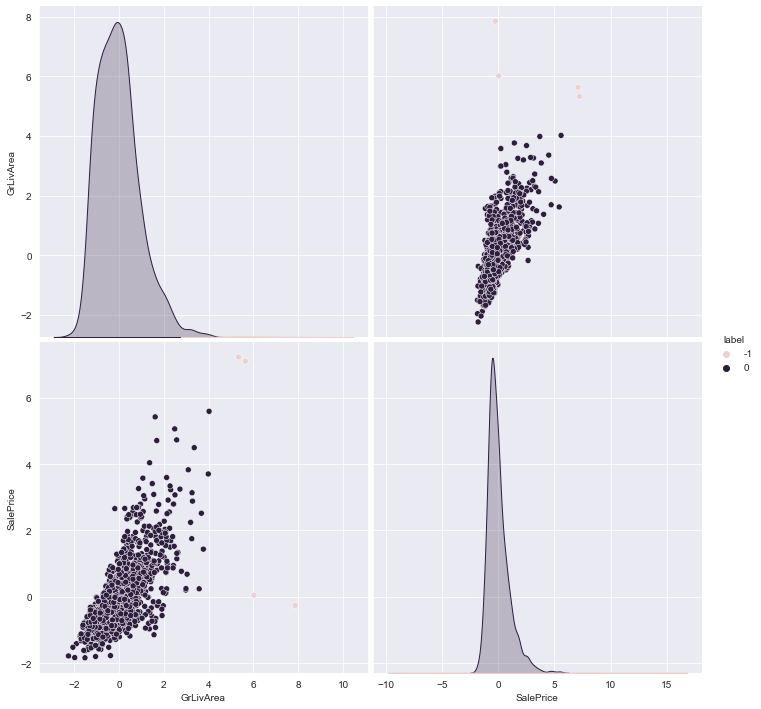

In [28]:
sns.pairplot(tmp, hue='label', size=5)
plt.show()

In [446]:
outlier_idx = list(outlier_idx.values) + [30, 88, 462, 631, 1322]
train.drop(outlier_idx, axis=0, inplace=True)

<p>
    결론:<br>
    산점도를 통해 두 개의 이상치를 찾아냈다. 두 점을 제거했다.<br>
    DBSCAN의 경우 총 4개의 포인트를 이상치로 판정했다.
</p>

<h3 style="text-align:center;">3. 훈련, 테스트 데이터 병합, 종속변수 분리</h3><br>
<h4>Outline</h4>
훈련데이터에서 이상치를 제거했다. 이제 테스트 데이터와 합친다. 종속변수는 따로 분리해준다.

In [447]:
train_size = train.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test), axis=0).drop(['SalePrice'], axis=1)

In [448]:
train.shape, test.shape, all_data.shape, y_train.shape

((1453, 80), (1459, 79), (2912, 79), (1453,))

<h3 style="text-align:center;">4. Clensing - Missing Value</h3><br>
<h4>Outline</h4>
결측치는 반드시 제거되어야 할 대상이다. 각 독립변수에 대한 이해를 바탕으로 결측치를 처리해본다.
<br><br>
<h4>결측치 처리 방법</h4>
<ol>
    <li><b>삭제:</b><br>
        가장 쉽고 강력한 방법이다. 행을 지우거나 열을 지우면 된다. 하지만 테스트 데이터에도 결측치가 존재할 수 있으므로 행을 지우는 것을 피한다.<br>
        열을 지우는 것은 중요한 변수를 제거할 위험이 있으므로 피할 수 있으면 피한다.</li>
    <li><b>특정값 대체:</b><br>
        변수에 대한 지식을 가지고 있다면 시도할 수 있는 방법이다. 예를 들어 부정적 의미를 가질 수 있는 등간형 변수가 극단적으로 많은 결측치를 가지고 있다면<br>
        결측치가 부정적인 의미일 가능성이 높다.
    <li><b>중심경향치 대체:</b><br>
        평균, 중앙값, 최빈값과 같은 중심경향치로 대체할 수 있다. 주로 연속형 변수를 중앙값, 카테고리 변수를 최빈값으로 대체할 수 있다.</li>
    <li><b>그 외: 단순확률대체, 다중대치법 등...</b><br>
</ol>
나는 각 변수의 설명을 본 뒤, 다음과 같이 처리했다.<br>
<ul>
    <li>
        연속형: 연관성 있는 카테고리 변수를 하나 선정, 카테고리 별 중앙값 대체.<br>or
        결측치일 수밖에 없는 경우 0으로 대체.
    </li>
    <li>
        카테고리형: value_counts로 분포를 파악 후 NA나 POOL과 같이 부정적 의미가 0개인 경우 None으로 대체 or<br>연관성 있는 카테고리 변수를 하나 선정, 카테고리 별 값의 분포 파악 후 최빈값 대체.
    </li>
</ul>

In [116]:
def compare_variance(standard, var):
    sns.scatterplot(x=all_data[standard], y=all_data[var])
    plt.xticks(rotation='90')
    plt.show()

    rlt = dict()
    for v in all_data[standard].unique():
        rlt[v] = all_data[all_data[standard] == v][var].value_counts()
    print(rlt)

<p>
    현재 결측치를 보유하고 있는 변수들
</p>

In [207]:
all_data.columns[all_data.isnull().sum() > 0]

Index(['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'],
      dtype='object')

ex1) MSZoning은 Neighborhood 별로 확인했을 때 특정 값에 치우져지므로 Neighborhood 별 최빈값으로 대체.

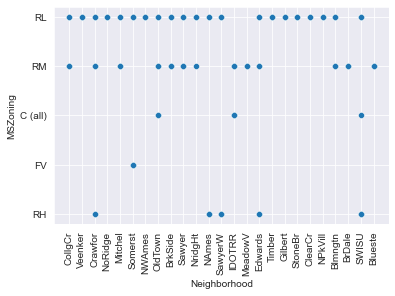

{'CollgCr': RL    253
RM     14
Name: MSZoning, dtype: int64, 'Veenker': RL    24
Name: MSZoning, dtype: int64, 'Crawfor': RL    91
RM    10
RH     2
Name: MSZoning, dtype: int64, 'NoRidge': RL    71
Name: MSZoning, dtype: int64, 'Mitchel': RL    104
RM      9
Name: MSZoning, dtype: int64, 'Somerst': FV    139
RL     43
Name: MSZoning, dtype: int64, 'NWAmes': RL    131
Name: MSZoning, dtype: int64, 'OldTown': RM         198
RL          39
C (all)      2
Name: MSZoning, dtype: int64, 'BrkSide': RM    65
RL    43
Name: MSZoning, dtype: int64, 'Sawyer': RL    148
RM      3
Name: MSZoning, dtype: int64, 'NridgHt': RL    165
RM      1
Name: MSZoning, dtype: int64, 'NAmes': RL    436
RH      7
Name: MSZoning, dtype: int64, 'SawyerW': RL    119
RH      6
Name: MSZoning, dtype: int64, 'IDOTRR': RM         68
C (all)    22
Name: MSZoning, dtype: int64, 'MeadowV': RM    37
Name: MSZoning, dtype: int64, 'Edwards': RL    178
RM     12
RH      2
Name: MSZoning, dtype: int64, 'Timber': RL    72
Name

In [117]:
compare_variance('Neighborhood', 'MSZoning')

ex2) LotFrontage는 Neighborhood 별 중앙값으로 대체.

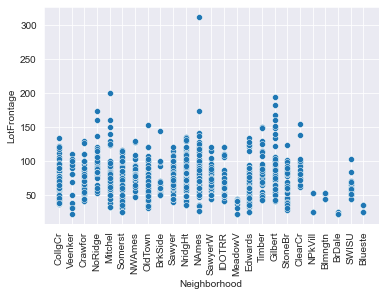

In [118]:
sns.scatterplot(x=all_data.Neighborhood, y=all_data.LotFrontage)
plt.xticks(rotation='90')
plt.show()

ex3) Alley는 NA를 가질 수 있는 순위형 변수이고, 이 값들이 결측치로 처리되었으므로 None으로 대체.

In [119]:
all_data.Alley.value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

ex4) Utilities는 극단적으로 AllPub으로 치우쳐져 있으므로 최빈값으로 대체.

In [121]:
all_data.Utilities.value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

ex5) GarageArea는 Garage가 없는 경우 결측치이므로 0으로 대체.

In [208]:
all_data.GarageArea.value_counts()

0.0      157
576.0     97
440.0     96
240.0     69
484.0     68
        ... 
443.0      1
263.0      1
962.0      1
186.0      1
803.0      1
Name: GarageArea, Length: 602, dtype: int64

In [449]:
all_data.MSZoning = all_data.groupby('Neighborhood').MSZoning.transform(lambda x: x.fillna(x.mode()[0]))
all_data.LotFrontage = all_data.groupby('Neighborhood').LotFrontage.transform(lambda x: x.fillna(x.median()))
all_data.Exterior1st = all_data.groupby('Neighborhood').Exterior1st.transform(lambda x: x.fillna(x.mode()[0]))
all_data.Exterior2nd = all_data.groupby('Neighborhood').Exterior2nd.transform(lambda x: x.fillna(x.mode()[0]))

for c in ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
          'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
          'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'KitchenQual']:
    all_data[c] = all_data[c].fillna('None')
    
for c in ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 
         'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']:
    all_data[c] = all_data[c].fillna(0)   
    
for c in ['Electrical', 'BsmtFullBath', 'Utilities', 
          'SaleType', 'Functional']:
    all_data[c] = all_data[c].fillna(all_data[c].mode()[0])

In [450]:
all_data.isnull().sum().sum()

0

<h3 style="text-align:center;">5. 파생변수 생성</h3><br>
<h4>Outline</h4>
파생변수를 생성해서 더욱 풍부한 데이터셋을 만든다.


In [451]:
all_data['HasMasVnr'] = all_data.MasVnrArea.apply(lambda x: 1 if x else 0)
all_data['Has2ndFlrSF'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x else 0)
all_data['HasGarageArea'] = all_data['GarageArea'].apply(lambda x: 1 if x else 0)
all_data['HasWoodDeckSF'] = all_data['WoodDeckSF'].apply(lambda x: 1 if x else 0)
all_data['HasOpenPorchSF'] = all_data['OpenPorchSF'].apply(lambda x: 1 if x else 0)
all_data['HasEnclosedPorch'] = all_data['EnclosedPorch'].apply(lambda x: 1 if x else 0)
all_data['Has3SsnPorch'] = all_data['3SsnPorch'].apply(lambda x: 1 if x else 0)
all_data['HasScreenPorch'] = all_data['ScreenPorch'].apply(lambda x: 1 if x else 0)
all_data['HasPoolArea'] = all_data['PoolArea'].apply(lambda x: 1 if x else 0)
all_data['HasMiscVal'] = all_data['MiscVal'].apply(lambda x: 1 if x else 0)

all_data['TotalBath'] = all_data['BsmtFullBath'] + all_data['BsmtHalfBath'] * 0.5\
+ all_data['FullBath'] + all_data['HalfBath'] * 0.5
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'] + all_data['BsmtFinSF1'] \
+ all_data['BsmtFinSF2']

<h3 style="text-align:center;">6. 변수 변환</h3><br>
<h4>Outline</h4>
연속형 변수의 정규성, 등분산성을 확보하기 위해 이들에게 로그, 박스콕스 변환을 적용한다.<br>
순서(순위)형 변수에는 라벨인코딩을 적용한다.<br>
등간형 변수에는 원핫인코딩을 적용한다.<br>
종속변수의 정규성을 확보하기 위해 종속변수에 로그변환을 적용한다.

In [452]:
nominal_vars = list(set(nominal_vars) - set(['Utilities']))

In [453]:
all_data[nominal_vars] = all_data[nominal_vars].astype('str')
all_data[order_vars] = all_data[order_vars].astype('str')

In [454]:
le = LabelEncoder()
for c in order_vars:
    all_data[c] = le.fit_transform(all_data[c])

In [415]:
all_data.drop(['PoolQC', 'PoolArea', 'Street'], axis=1, inplace=True)

In [455]:
numeric_vars = all_data.dtypes[all_data.dtypes != "object"].index
skewed_vars = numeric_vars[abs(all_data[numeric_vars].skew()).sort_values(ascending=False) > 0.5]

for var in skewed_vars:
    all_data[var] = boxcox1p(all_data[var], .15)

In [456]:
all_data = pd.get_dummies(all_data)

In [457]:
y_train = np.log1p(y_train)

<h3 style="text-align:center;">7. 훈련, 테스트 데이터 분할</h3><br>
<h4>Outline</h4>
다시 훈련데이터와 테스트데이터를 분할한다.


In [438]:
X_train, X_test = all_data.iloc[:train_size, :], all_data.iloc[train_size:, :]

In [439]:
X_train.shape, X_test.shape, y_train.shape

((1453, 231), (1459, 231), (1453,))

<h2 style="text-align:center;">Modelling</h2><br>

In [184]:
def rmsle_cv(model):
    return np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring='neg_mean_squared_error',
                   cv=5, verbose=0, n_jobs=-1))

<h3 style="text-align:center;">1. GridSearch Cross Validation</h3><br>

In [461]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso())
])
model_elasticNet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(max_iter=5000))
])
model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr())
])

model_svr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', SVR())
])

grid_param_lasso = {
    'model__alpha': 0.0001 * np.arange(1, 100)
}
grid_param_elasticNet = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__l1_ratio': 0.001 * np.arange(1, 10)
}
grid_param_krr = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__degree': [1, 2, 3],
    'model__kernel': ['polynomial'],
    'model__coef0': [2.5]
}
grid_param_svr = {
    'model__C': [5, 10, 20],
    'model__gamma': [.0001, .0002, .0003, .0004, .0005, .0006, .0007, .0008, .0009, .001],
    'model__epsilon': [.001, .002, .003, .004, .005, .006, .007, .008, .009, .01]
}

In [462]:
search_lasso = GridSearchCV(model_lasso, grid_param_lasso, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
search_lasso.best_params_

{'model__alpha': 0.0004}

In [463]:
search_elasticNet = GridSearchCV(model_elasticNet, grid_param_elasticNet, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
search_elasticNet.best_params_

{'model__alpha': 0.0085, 'model__l1_ratio': 0.009000000000000001}

In [464]:
search_krr = GridSearchCV(model_krr, grid_param_krr, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
search_krr.best_params_

{'model__alpha': 0.0099,
 'model__coef0': 2.5,
 'model__degree': 1,
 'model__kernel': 'polynomial'}

In [465]:
search_svr = GridSearchCV(model_svr, grid_param_svr, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
search_svr.best_params_

{'model__C': 20, 'model__epsilon': 0.01, 'model__gamma': 0.0005}

In [466]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(alpha=0.0004))
])
model_elasticNet = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(alpha=0.0085, l1_ratio=0.009000000000000001))
])
model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr(alpha=0.0099,
                        kernel='polynomial',
                        degree=1,
                        coef0=2.5))
])
model_svr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', SVR(C=20,gamma=0.0005, epsilon=0.01))
])
model_xgbr = XGBRegressor(colsample_bytree=0.4, learning_rate=0.00898718134841855, max_depth=8, 
                             n_estimators=2200, reg_alpha=0.036142628805195254, reg_lambda=0.03188665185506858,
                             subsample=0.6, random_state =42)
model_gbr = gbr(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state=5)
model_lgbm = LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
stack_gen = StackingCVRegressor(regressors=(model_lgbm, model_lasso, model_elasticNet, model_krr, model_gbr, model_svr),
                               meta_regressor=model_xgbr,
                               use_features_in_secondary=True)

In [467]:
models = [
    model_lasso, model_elasticNet, model_krr, model_svr, model_gbr, model_xgbr, model_lgbm
]
cross_score = {
    'Lasso': 0,
    'ElasticNet': 0,
    'Kernel Ridge': 0,
    'SVR': 0,
    'GradientBoosting': 0,
    'XGBoost': 0,
    'LightGBM': 0,
}

for idx, model in enumerate(models):
    cross_score[list(cross_score.keys())[idx]] = rmsle_cv(model).mean()

In [468]:
cross_score

{'Lasso': 0.10761405270551197,
 'ElasticNet': 0.10853333263072991,
 'Kernel Ridge': 0.11045498246247612,
 'SVR': 0.1255458408999493,
 'GradientBoosting': 0.11249024265035013,
 'XGBoost': 0.10969197946345513,
 'LightGBM': 0.11014405389573996}

In [460]:
cross_score

{'Lasso': 0.10761405270551197,
 'ElasticNet': 0.10853516505117519,
 'Kernel Ridge': 0.11045498246247612,
 'SVR': 0.12683742711926752,
 'GradientBoosting': 0.11249024265035013,
 'XGBoost': 0.10969197946345513,
 'LightGBM': 0.11014405389573996}

In [471]:
models.append(stack_gen)
for model in models:
    model = model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [473]:
cross_score

{'Lasso': 0.10761405270551197,
 'ElasticNet': 0.10853333263072991,
 'Kernel Ridge': 0.11045498246247612,
 'SVR': 0.1255458408999493,
 'GradientBoosting': 0.11249024265035013,
 'XGBoost': 0.10969197946345513,
 'LightGBM': 0.11014405389573996}

In [476]:
def blend(X):
    return ((0.10 * model_lasso.predict(X)) + \
            (0.10 * model_elasticNet.predict(X)) + \
            (0.05 * model_krr.predict(X)) + \
            (0.15 * model_xgbr.predict(X)) + \
            (0.15 * model_lgbm.predict(X)) + \
            (0.10 * model_svr.predict(X)) + \
            (0.35 * stack_gen.predict(np.array(X))))
np.sqrt(mse(y_train, blend(X_train)))

0.04318226448229026

In [478]:
def blend(X):
    return ((0.10 * model_lasso.predict(X)) + \
            (0.10 * model_elasticNet.predict(X)) + \
            (0.10 * model_krr.predict(X)) + \
            (0.15 * model_xgbr.predict(X)) + \
            (0.15 * model_lgbm.predict(X)) + \
            (0.05 * model_svr.predict(X)) + \
            (0.35 * stack_gen.predict(np.array(X))))
np.sqrt(mse(y_train, blend(X_train)))

0.04622378279372394

In [475]:
def blend(X):
    return ((0.15 * model_lasso.predict(X)) + \
            (0.15 * model_elasticNet.predict(X)) + \
            (0.05 * model_krr.predict(X)) + \
            (0.05 * model_svr.predict(X)) + \
            (0.05 * model_gbr.predict(X)) + \
            (0.15 * model_xgbr.predict(X)) + \
            (0.05 * model_lgbm.predict(X)) + \
            (0.35 * stack_gen.predict(np.array(X))))

np.sqrt(mse(y_train, blend(X_train)))

0.044187492344825406

In [190]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = score = np.expm1(blend(X_test))
sub.to_csv('submission.csv',index=False)